# Cy Gilman Detailed Project Proposal

12/6/2020

In [9]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Scientific Question:

How does ENSO affect California's snow reserves, and in turn the element of the state's water supply that comes from snow runoff? Can we use a Nino value to help predicting these quantitites? I will address this question on a larger scale, looking at spatial/temporal snowfall satellite data for the entire state, and focusing in particular on particular points of interest, analyzing measured snow water content (measured in inches) and runoff from nearby rivers.

The challenge of working on snow in California (and particularly in Central/Southern California, as with the areas of my focus) is that values of "0" are quite frequent, and the data is not continuous but a series of spikes. I would guess that the autocorrelation of the snow measurements would be quite low!

I believe in most cases, it will be useful to group the data into yearly totals/averages rather than monthly, given that we are curious about the mid-length effects of something such as ENSO - we are interested in whether ENSO has an impact on how big of a snow season one will have in a given year.

For each snow measurement I (tentatively) will do a correlation-based significance test with the El Niño value (I don't really care too much about the Niño categories) and if the null hypothesis is rejected, make a linear regression-based (with both Nino and time as factors) prediction (with a confidence interval, of course) of both the map for precipitation, and numbers (also with confidence intervals) at each of the test stations.

I do not want to analyse the relationship between runoff flow (which also incorporates rainfall and other measurements that ENSO likely influences, yet are outside the scope of my project) and ENSO directly. Rather, I want to establish a link between ENSO and snowfall, and then analyse the link between snowfall and runoff, so as (in part) to show the extent to which fluctuations in the state's water patterns are due to seasonal runoff... and in turn how much of ENSO's effect on the state is from snowfall as it is rainfall et al. I want to create a correlation "heat map", like often done in class with autocorrelation, between snowfall and runoff in corresponding stations -- this is in order to analyse the "lag times" or melting periods... how much of a lag exists between correlated spikes in each quantity, the extent to which these spikes do correlate, the months in which they tend to occur, etc. Hopefully having come up with predictions for snowfall for each site, I will be able to do the same with the runoff.

## Data Sets:

#### ECMWF-IFS-Cy41r2:

Text(0.5, 1.0, 'Average Snowfall Flux')

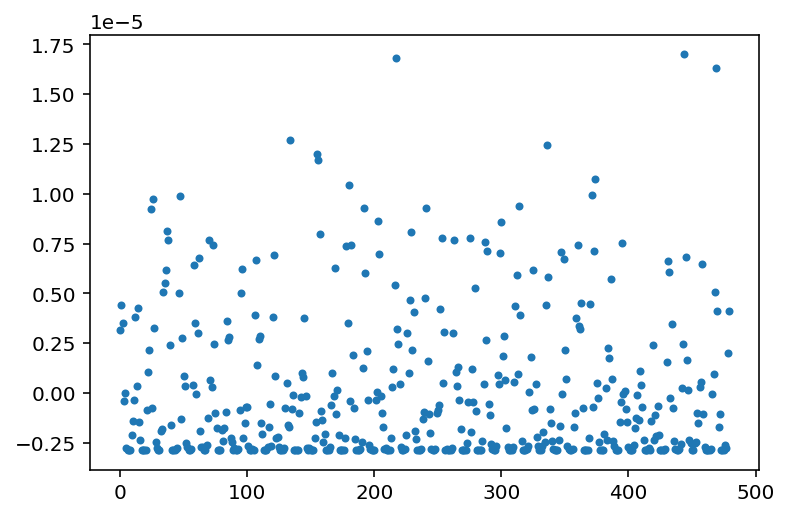

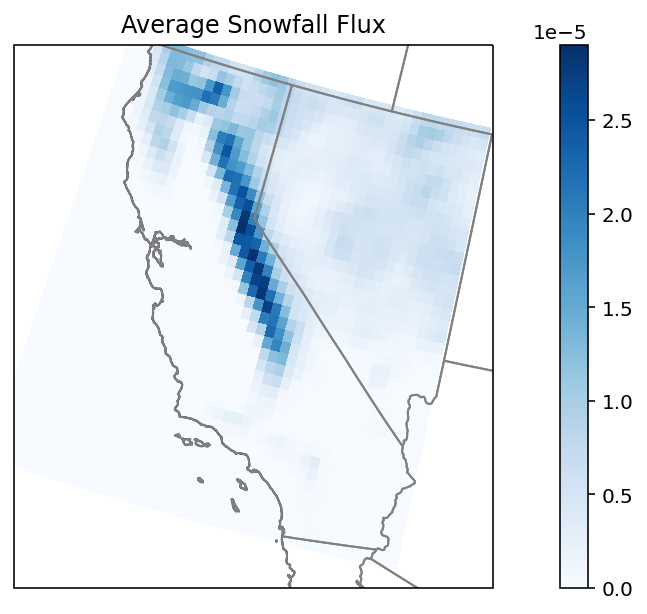

In [35]:
ecmwf = xr.open_dataset('Data/data.nc', decode_times=False)
ecmwf_array = ecmwf.to_array()
ecmwf_array = ecmwf_array.mean(dim = 'variable')
ecmwf_mean = ecmwf_array.mean(dim = 'T')
ecmwf_a = ecmwf_array - ecmwf_mean
ecmwf_a_plot = ecmwf_a.mean(axis = (1,2))
plt.plot(ecmwf_a_plot,'.')

proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-124, -114, 32, 42]

xr.plot.pcolormesh(ecmwf_mean,transform=proj_dta, ax = ax, cmap='Blues')
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.set_extent(extent)
ax.set_title('Average Snowfall Flux')

### CA DWS CSV Files -- Individual Stations:
   Paired up between one station measuring snow, and another measuring the full natural flow, i.e. of a river taking runoff water from the snow station as its source. I am only considering the relationship between the snow levels of each station to its relevant river, not to any of the others.
   
Each of the rivers selected is also very relevant to California/LA water infrastructure: the San Joaquin River is the source for much of the Central Valley's agriculture industry, the Kern river leads into the California Aqueduct, and the Owens river connects to the L.A. Aqueduct -- a fact that led directly to the dramatic draining of Owens lake when it was first built, and has been continuously controversial since.

#### 1a. Piute Pass (snow)

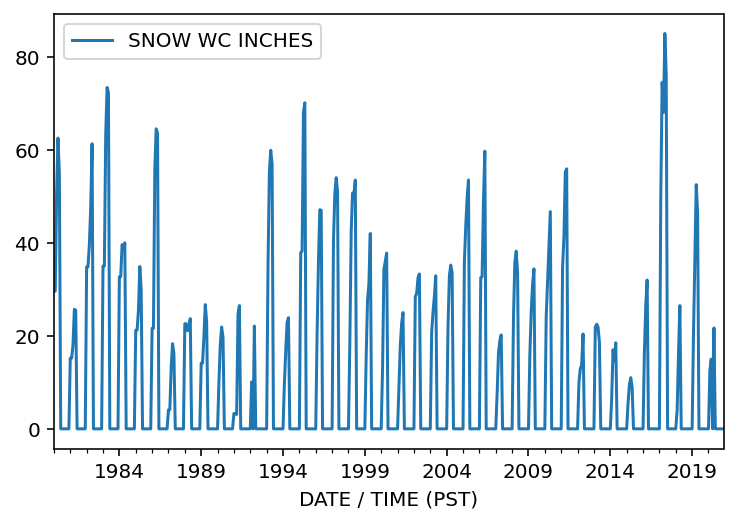

In [139]:
PPS = pd.read_csv('Data/PPS.csv', index_col = 0, parse_dates=True)
PPS = PPS.drop(columns = 'Unnamed: 2')
PPS = PPS.where(PPS != '--', other = 0)
PPS=PPS.astype(float)
PPS.plot()

#### 1b. San Joaquin River below Friant (runoff)

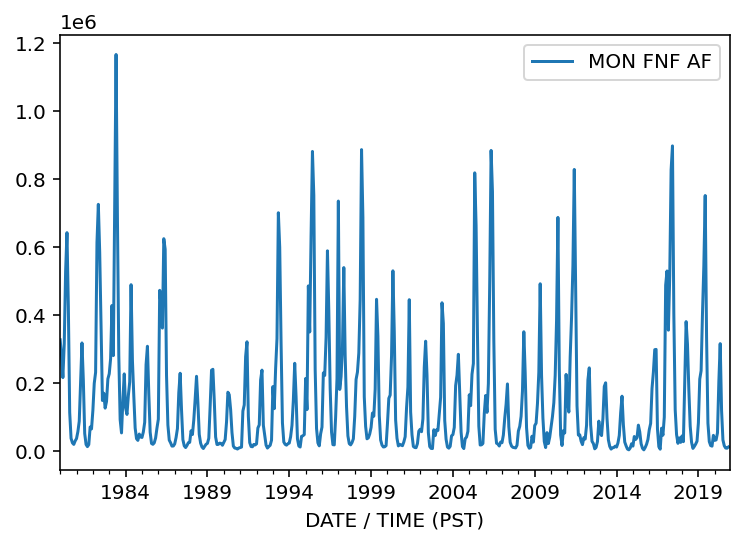

In [138]:
SJF = pd.read_csv('Data/SJF.csv', index_col = 0, parse_dates=True)
SJF = SJF.drop(columns = 'Unnamed: 2')
SJF = SJF.where(SJF != '--', other = 0)
SJF = SJF.replace(',','')
SJF['MON FNF AF'] = SJF['MON FNF AF'].str.replace(',', '').astype(float)
SJF.plot()
#notice the 1e6 at the top of the y axis. This graph's units are more similar to the next river than first appears.

#### 2a. Bighorn Plateau (snow)

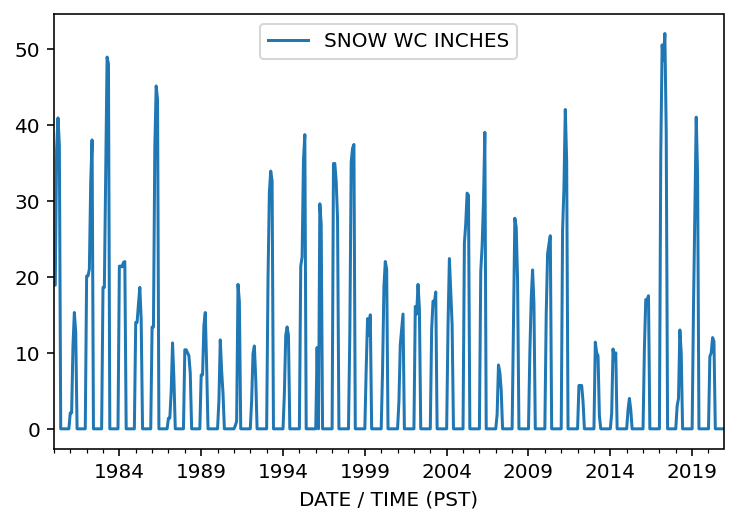

In [140]:
BGH = pd.read_csv('Data/BGH.csv', index_col = 0, parse_dates=True)
BGH = BGH.drop(columns = 'Unnamed: 2')
BGH = BGH.where(BGH != '--', other = 0)
BGH = BGH.astype(float)
BGH.plot()

#### 2b. Kern River below Isabella (runoff)

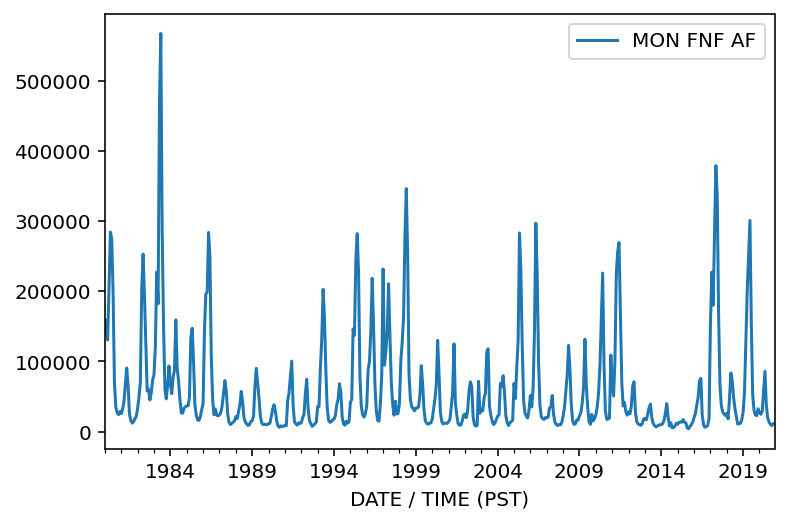

In [141]:
KRI = pd.read_csv('Data/KRI.csv', index_col = 0, parse_dates=True)
KRI = KRI.drop(columns = 'Unnamed: 2')
KRI = KRI.where(KRI != '--', other = 0)
KRI = KRI.replace(',','')
KRI['MON FNF AF'] = KRI['MON FNF AF'].str.replace(',', '').astype(float)
KRI.plot()

#### 3a: Bishop Lake (snow)

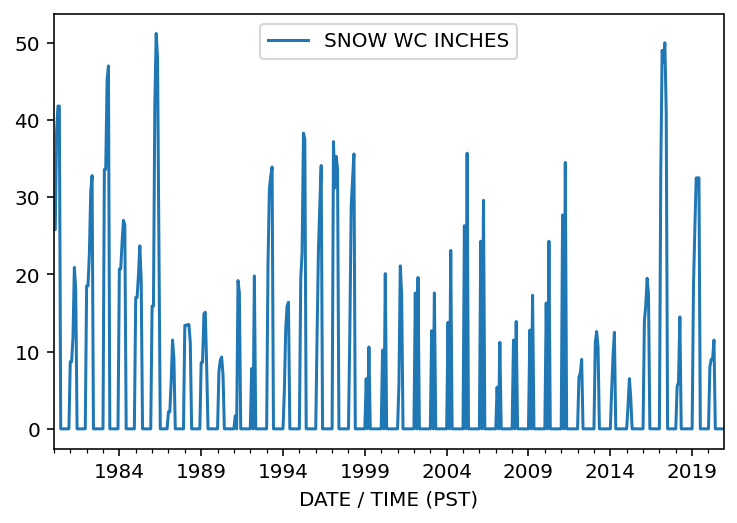

In [142]:
BSP = pd.read_csv('Data/BSP.csv', index_col = 0, parse_dates=True)
BSP = BSP.drop(columns = 'Unnamed: 2')
BSP = BSP.where(BSP != '--', other = 0)
BSP = BSP.astype(float)
BSP.plot()

#### 3b: Owens River - Long Valley (runoff)

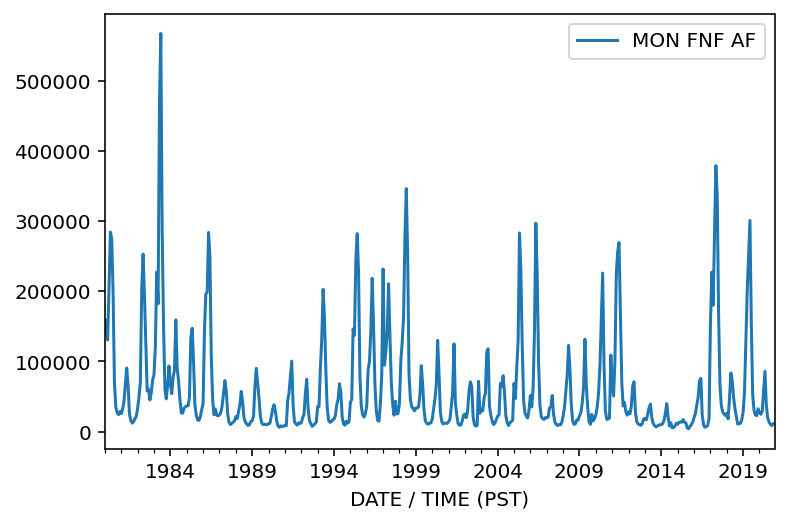

In [143]:
OWL = pd.read_csv('Data/KRI.csv', index_col = 0, parse_dates=True)
OWL = OWL.drop(columns = 'Unnamed: 2')
OWL = OWL.where(OWL != '--', other = 0)
OWL = OWL.replace(',','')
OWL['MON FNF AF'] = OWL['MON FNF AF'].str.replace(',', '').astype(float)
OWL.plot()